In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora
import os
import re
import string
from bs4 import BeautifulSoup
from tqdm import tqdm
from time import time
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

# Load Data

In [4]:
path = './nyt-comments'
files_comments = [os.path.join(path, file) for file in os.listdir(path) if file.startswith('C')]
comments = []
for file in files_comments[:1]:
    comments.extend(pd.read_csv(file, low_memory=False)['commentBody'].dropna().values)
    
print('Loaded Comments: {}'.format(len(comments)))

Loaded Comments: 231449


In [5]:
n = 5000    # Number of comments to use in the LDA
re_punctuation = re.compile('['+string.punctuation+']')   # To remove punctuation
tokenizer = RegexpTokenizer('\w+')    # To tokenize the comments
stop = stopwords.words('english')
preprocessed_comments = []
for comment in tqdm(np.random.choice(comments, n)):
    comment = BeautifulSoup(comment, 'lxml').get_text().lower()    # Remove html
    comment = re_punctuation.sub(' ', comment)                     # Remove punctuation
    comment = tokenizer.tokenize(comment)                          # Tokenize comments
    comment = [word for word in comment if word not in stop]       # Remove stopwords
    preprocessed_comments.append(comment)
    
wordFrequency = Counter()
for comment in preprocessed_comments:
    wordFrequency.update(comment)                                  # Count overall word frequency
print('Unique Words In Comments: {}'.format(len(wordFrequency)))

minimumWordOccurrences = 5
# Remove rare words
texts = [[word for word in comment if wordFrequency[word] > minimumWordOccurrences] for comment in preprocessed_comments]
dictionary = corpora.Dictionary(texts)                             # Create word dictionary
vocabulary = [dictionary[i] for i in dictionary.keys()]
print('Documents/Comments: {}'.format(len(texts)))

corpus = [dictionary.doc2bow(doc) for doc in texts]                # Create corpus

def makesparse(mycorpus, ncolumns):
    data, row, col = [], [], []
    for cc, doc in enumerate(mycorpus):
        for word in doc:
            row.append(cc)
            col.append(word[0])
            data.append(word[1])
    X = csr_matrix((np.array(data), (np.array(row), np.array(col))), shape=(cc+1, ncolumns))
    return X

X = makesparse(corpus, len(dictionary))                            # sparse matrix
print('Train Shape:\t{}'.format(X.shape))

100%|██████████| 5000/5000 [00:01<00:00, 2602.39it/s]


Unique Words In Comments: 21455
Documents/Comments: 5000
Train Shape:	(5000, 5118)


In [13]:
numberTopics = 20

In [7]:
model_sklearn = LatentDirichletAllocation(n_components=numberTopics, 
                                          learning_method='online',
                                          n_jobs=16,
                                          max_iter = 1,
                                          total_samples = 10000,
                                          batch_size = 20)

perplexity_sklearn = []
timestamps_sklearn = []
start = time()
for _ in tqdm(range(100)):
    model_sklearn.partial_fit(X)
    perp_sklearn.append(model_sklearn.perplexity(X))        # Append metric
    times_sklearn.append(time()-start)

for i, topic in enumerate(model_sklearn.components_.argsort(axis=1)[:, -10:][:, ::-1], 1):
    print('Topic {}: {}'.format(i, ' '.join([vocabulary[id] for id in topic])))

100%|██████████| 100/100 [36:38<00:00, 22.03s/it]

Topic 1: going taxes made low name laws said 5 elected large
Topic 2: people would many like us get way know need go
Topic 3: see us trump america world russia class end mexico sense
Topic 4: 1 court justice non 2 constitution supreme result lose question
Topic 5: states vote nation power united bannon words state well history
Topic 6: election job next wonder 10 almost long national fair hear
Topic 7: law past may congress fight 4 senate issues least looks
Topic 8: news times article intelligence report likely would com current party
Topic 9: democratic actions state rich thinking paid clear citizens answer policy
Topic 10: trump president obama mr donald first office going man lies
Topic 11: trump american putin government people country lot must think last
Topic 12: years time get clinton new year like white never put
Topic 13: home free 3 number ask speak head market ways usa
Topic 14: better would made course perhaps middle line based supporters fox
Topic 15: public let truth nyt 

In [8]:
model_gensim = LdaModel(num_topics=numberTopics,
                        id2word=dictionary,
                        iterations=10,
                        passes=1,
                        chunksize=50,
                        alpha='auto',
                        eta='auto',
                        update_every=1)


perp_gensim = []
times_gensim = []
start = time()
for _ in tqdm(range(100)):
    model_gensim.update(corpus)
    perp_gensim.append(np.exp(-1 * model_gensim.log_perplexity(corpus)))
    times_gensim.append(time() - start)
    
for i, topic in enumerate(model_gensim.get_topics().argsort(axis=1)[:, -10:][:, ::-1], 1):
    print('Topic {}: {}'.format(i, ' '.join([vocabulary[id] for id in topic])))

  5%|▌         | 5/100 [00:17<05:39,  3.58s/it]/anaconda3/envs/ML/lib/python3.6/site-packages/gensim/models/ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
100%|██████████| 100/100 [07:06<00:00,  4.20s/it]

Topic 1: state article point change rights given court important rather words
Topic 2: states power vote fact nation free job place democracy voters
Topic 3: people like get know think need new also times public
Topic 4: look far anything actually else understand working countries citizens including
Topic 5: women men though lost rest march social came woman non
Topic 6: make want every money said pay maybe making 2 start
Topic 7: business high put children class end try wonder line game
Topic 8: may democrats less problem law democratic 1 majority politics actions
Topic 9: us country time world america republicans americans back take party
Topic 10: find everyone needs future foreign case agree home issues 3
Topic 11: congress give lot nyt run human face dangerous cabinet win
Topic 12: government election long gop away matter clear elect leader justice
Topic 13: care health say without insurance system aca call healthcare millions
Topic 14: american going day little got bad press mean

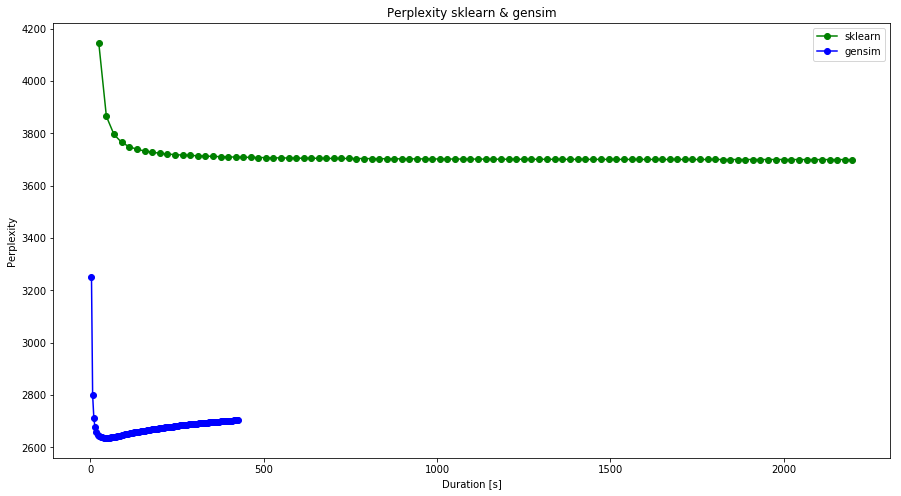

In [9]:
plt.figure(figsize=(15,8))
plt.plot(timestamps_sklearn, perp_sklearn, '-o', label='sklearn', c='g')
plt.plot(timestamps_gensim, perp_gensim, '-o', label='gensim', c='b')
plt.title('Perplexity sklearn & gensim')
plt.xlabel('Duration [s]')
plt.ylabel('Perplexity')
plt.legend()
plt.show()